<a href="https://colab.research.google.com/github/anushree825/speech_proj/blob/main/SSP_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install noisereduce

In [ ]:
import os
import scipy
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt 
import noisereduce as nr
import audioread
import IPython

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

path = "/content/drive/MyDrive/speech/assign2/name.wav"


In [ ]:
def time_scale_mod(filename,dur):
  y, sr   = librosa.load(str(filename))
  D       = librosa.stft(y, n_fft=2048)
  D_fast  = librosa.phase_vocoder(D, dur)
  y_fast  = librosa.istft(D_fast)
  return y_fast,sr
y,sr = time_scale_mod(path,2)
IPython.display.Audio(data=y, rate=sr) 

In [ ]:
def pitch_scaling(filename,steps):
  y, sr = librosa.load(str(filename))
  y_third = librosa.effects.pitch_shift(y, sr, n_steps=steps)
  return y_third,sr
y,sr = pitch_scaling(path,2)
IPython.display.Audio(data=y, rate=sr)   

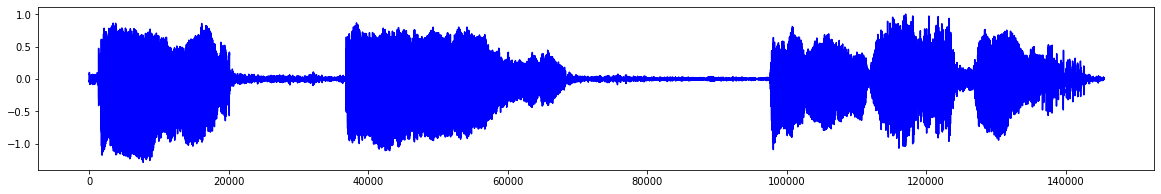

In [ ]:
def amplitude_scaling(filename):
#   Fs,data=wavfile.read(str(filename))
  data, Fs = librosa.load(str(filename))
  max_amp = max(data)
  data = data/max_amp
  fig, ax = plt.subplots(figsize=(20,3))
  ax.plot(data,color='blue')
  #plt.show(data)
amplitude_scaling(path)
 


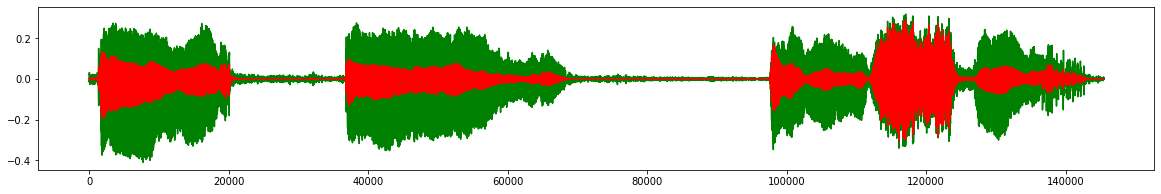

In [ ]:
def noise_reduction(filename):
#   Fs,data=wavfile.read(str(filename))
    data, Fs = librosa.load(str(filename))
    reduced_noise = nr.reduce_noise(y=data, sr=Fs)
    fig, ax = plt.subplots(figsize=(20,3))
    ax.plot(data,color='green')
    ax.plot(reduced_noise,color='red')
noise_reduction(path)

In [ ]:

def framing(filename,window='hann',frameLength=20,shiftFrame=25):
    signal, fs = librosa.load(str(filename))
    # fs,signal = wavfile.read(str(filename))
    #type(signal)
    sigLen=len(list(signal))
  
    outFrames=[]
    N=int(frameLength*fs/1000)
    Nshift=int(shiftFrame*fs/1000)
    window=scipy.signal.hann(N)

    numFrames=int(np.floor((sigLen-N)/Nshift) +1 )
    print(numFrames)
    for i in range(0,numFrames):
        sigSlice=signal[N*i:(i+1)*N]
        # frame=np.dot(window,sigSlice)
        frame = map(lambda x,y: x*y, window, sigSlice)
        outFrames.append(list(frame))
    return(outFrames, fs)
x,y = framing(path)
print(x)    

264
[[-0.0, -7.998982064230448e-07, -2.8783705114626914e-06, -7.222023761301818e-06, -1.0737363066758048e-05, -1.623493728895333e-05, -1.2473337428499874e-05, -1.7417974001418096e-05, -2.171199798675886e-05, -1.164649852781966e-05, -2.0010325520130114e-05, -3.7125912471364404e-06, 1.3883387151793838e-05, 4.0473416494258e-05, 6.67586346331878e-05, 9.18737356441886e-05, 0.00014071789468563176, 0.00024594717593759516, 0.0002747236879535462, 0.0003302255128846924, 0.00045287913339996046, 0.0004430297890734918, 0.0005107024644083949, 0.0005957305102383841, 0.0006866382518877352, 0.0007761282830882568, 0.0008872065796566549, 0.000958968286312483, 0.0010496878058388738, 0.0013463491986758756, 0.001387588953300217, 0.0013967772939541803, 0.0013829370487583898, 0.0014675336422392325, 0.0016242125662485976, 0.001389850440285679, 0.001557294298208268, 0.0016231556611293306, 0.0016028111942921744, 0.0017481630338361637, 0.0016297142120862247, 0.0016870116081734742, 0.0017530595995082655, 0.0018233

In [ ]:
temp, fs = framing(str(path))
temp = np.array(temp)
print(temp, temp.shape, fs)

264
[[-0.00000000e+00 -7.99898206e-07 -2.87837051e-06 ... -1.43248444e-06
  -3.87462802e-07 -0.00000000e+00]
 [-0.00000000e+00 -2.58053304e-07 -1.27060370e-06 ... -1.55524692e-06
  -2.58633905e-07 -0.00000000e+00]
 [-0.00000000e+00 -6.02485893e-08  3.65264983e-07 ... -3.20081485e-06
  -6.16643850e-07 -0.00000000e+00]
 ...
 [ 0.00000000e+00 -6.26706396e-06 -1.72785130e-05 ... -1.75160779e-05
  -1.77980061e-06  0.00000000e+00]
 [ 0.00000000e+00  1.36751169e-06  1.36476779e-05 ... -2.12061055e-05
  -4.10400242e-06  0.00000000e+00]
 [ 0.00000000e+00  3.19708830e-06 -2.03332035e-05 ...  1.95207034e-05
   4.22203243e-06  0.00000000e+00]] (264, 441) 22050


In [ ]:
from scipy.linalg import toeplitz
from scipy.signal import filtfilt
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    # print(result)
    return result[(int)(result.size/2):]

def lpcCoeffs(data,orderLPC=13,window='hann',G=1):
    # data,fs = librosa.load(frame)
    # signal=np.asarray(data)
    sigLen=len((list(data)))
    window = scipy.signal.hann(sigLen,True)
    
    # sigLPC=np.dot(window,data)
    sigLPC = list(map(lambda x,y: x*y, window, data))
    # print(sigLPC)
    sigEnergy=sum(np.power(sigLPC,2))

    # LPC Analysis 
    autoCorr=autocorr(sigLPC)
    sigCorr=autoCorr/np.max(abs(autoCorr))

    A=sigCorr[1:orderLPC-1]
    A=toeplitz(A)
    A=(-1)*np.linalg.inv(A)

    r=sigCorr[2:orderLPC]
    rT=np.transpose(r)
  
    L=np.transpose(np.dot(rT,A))
    # Coefficeint Extraction
    # print(L)
    # lpcs=np.concatenate((np.array([1]),L),axis=0)
    lpcs = np.array([1] + list(L))
    # Signal Filtering 
    tempo = np.array([0] + list(-1*lpcs[2:]))

    filteredSig=filtfilt(tempo,G,sigLPC)

    #Residual Computation 
    lpResidual=sigLPC-filteredSig
    return(lpResidual)


def fileLPCRes(fi,orderLPC=13,window='hann',G=1):
    print("Hello")
    outFrames, fs = framing(fi)
    
    print(np.array(outFrames).shape)
    fileres=[]
    # Now, frame-wise LPC caluclation 
    for i in range(0,len(outFrames)):
        frame_lpres=lpcCoeffs(np.asarray(outFrames[i]))
        fileres.append(frame_lpres)

    return np.asarray(fileres), fs

In [ ]:
temp, fs = fileLPCRes(path)
temp = np.array(temp)
print(temp, temp.shape)

Hello
264
(264, 441)
[[ 6.77626358e-21 -3.70275682e-05 -2.67498374e-05 ... -1.30338256e-05
   4.38455637e-05  1.01643954e-20]
 [-2.54109884e-21  9.93077496e-07  8.28968218e-07 ... -5.97969711e-06
   9.01554674e-07 -1.69406589e-21]
 [-0.00000000e+00  8.74877519e-09  4.33483098e-08 ...  1.47212550e-08
  -2.35790858e-08 -1.65436123e-24]
 ...
 [ 4.23516474e-22  4.88702620e-06  1.95346462e-06 ... -7.78392165e-08
   7.05108168e-06 -8.47032947e-22]
 [-2.64697796e-23 -1.00515314e-06 -1.57744241e-06 ... -8.82797577e-09
  -5.69156206e-07  0.00000000e+00]
 [ 2.11758237e-22 -4.98906143e-06  2.90406624e-06 ... -5.61488164e-06
  -6.20396754e-06  2.11758237e-22]] (264, 441)


In [ ]:
def mfcc(y,sr=22050, S=None, n_mfcc=15, dct_type=2, norm='ortho',flag=False):
    # y,sr = librosa.load(file)
    mfccs = librosa.feature.mfcc(y=y,sr=sr, n_mfcc=n_mfcc)

    if(flag):
        print('Plotting the spectrogram')
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfccs, x_axis='time')
        plt.colorbar()
        plt.title('MFCC')
        plt.tight_layout()
        plt.show()

    return(mfccs)

In [ ]:
print(mfcc(temp[1]).shape)

(15, 1)


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=441
  n_fft, y.shape[-1]


In [ ]:
X = []
Y = []
test_paths = []

In [ ]:
# FRAME BY FRAME
import os, random
random.seed(42)
positive_path = "/content/drive/MyDrive/speech/assign2/"

for fi in os.listdir(positive_path):
    path = os.path.join(positive_path, fi)
    if random.random() >= 0.6:
        test_paths.append((path, 1))
        continue
    temp, fs = fileLPCRes(path)
    temp = np.array(temp)
    # temp_signal, fs = preProcessingBlock(path)
    # peaks = get_peaks(temp_signal, 22050, 10 * 0.0001, 100)
    # print(peaks)
    # jitt = get_jitt(peaks)
    # shim = get_shim_2(peaks)
    # print(temp, temp.shape, fs)

    # hnrs = params(path)
    # print("hnrs",hnrs)
    # for arr, hnr in zip(temp, hnrs):
    for arr in temp:
        # mf = list(mfcc(arr)) + [jitt, shim]
        mf = list(mfcc(arr)) 
        X.append(mf)
        Y.append(1)

Hello
264
(264, 441)


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=441
  n_fft, y.shape[-1]


Hello
26
(26, 441)
Hello
2
(2, 441)


In [ ]:
# CONCAT ALL FRAMES

# import os, random
# positive_path = "/gdrive/My Drive/speech/spasmodic dysphonia_temp"

for fi in os.listdir(positive_path):
  path = os.path.join(positive_path, fi)
  if random.random() >= 0.6:
    test_paths.append((path, 1))
    continue
  temp, fs = framing(path)
  temp = np.array(temp)
  curr = []
  for arr in temp:
    curr.append(mfcc(arr))
  curr = np.array(curr).reshape(-1,15)
  # print(curr.reshape(-1,15).shape)
  Y.append(0)
  X.append(curr)

471


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=441
  n_fft, y.shape[-1]


264
26
2
0
2
37


In [ ]:
X = np.array(X)
Y = np.array(Y)
print(Y.shape)
# test = X.reshape((-1, 16))
# print(X[0].shape)

T = []
for i in X:
    i = np.array(i)
    print(i.flatten().shape)
    T.append(i.flatten())
T = np.array(T)

import tensorflow as tf
test = tf.keras.preprocessing.sequence.pad_sequences(T,truncating="post", padding="post")

(299,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15,)
(15

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


In [ ]:
from sklearn.svm import SVC
# svm_model = SVC(kernel = 'rbf', C=1)
svm_model = SVC(kernel = 'rbf', C=1, class_weight="balanced")
svm_model = svm_model.fit(X=test, y=Y)

In [ ]:
print(test.shape)
corrects = 0
incorr = 0

(299, 7065)


In [ ]:
# 17
test_X = []
test_Y = []

In [ ]:
for fi, label in test_paths:
    temp, fs = fileLPCRes(fi)
    temp = np.array(temp)
    # print(temp, temp.shape, fs)
    # dic = {}
    temper = []
    # temp_signal, fs = preProcessingBlock(fi)
    # peaks = get_peaks(temp_signal, 22050, 10 * 0.0001, 100)
    # # print(peaks)
    # jitt = get_jitt(peaks)
    # shim = get_shim_2(peaks)
    
    # for arr in temp:
    #   # fr = list(mfcc(arr)) + [jitt, shim] 
    #   temper.append(mfcc(arr))
    #   hnrs = params(path)
    # for arr, hnr in zip(temp, hnrs):
    for arr in temp:
        # mf = list(mfcc(arr)) + [jitt, shim]
        mf = list(mfcc(arr)) 
        temper.append(mf)
    test_X.append(temper)
    test_Y.append(label)
        # print(np.array([fr]).shape)
        # lab = logistic_model.predict(np.array([fr]).reshape(1,15))
        # dic[lab[0]] = dic.get(lab[0], 0) + 1
    # lab = max(dic, key=dic.get)
    # if lab == label:
        # corrects += 1
    # else:
        # incorr += 1


Hello
471
(471, 441)


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=441
  n_fft, y.shape[-1]


Hello
0
(0,)
Hello
2
(2, 441)
Hello
37
(37, 441)


In [ ]:


# 19
pred = []
for fi, label in zip(test_X, test_Y):
  # temp, fs = framing(fi)
  temp = np.array(fi)
  # print(temp, temp.shape, fs)
  dic = {}
  for arr in temp:
    # lab = svm_model.predict(np.array([arr]).reshape(1,16))
    lab = svm_model.predict(np.array([arr])
    dic[lab[0]] = dic.get(lab[0], 0) + 1
  lab = max(dic, key=dic.get)
  pred.append(lab)
  if lab == label:
    corrects += 1
  else:
    incorr += 1



SyntaxError: ignored